In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
! pip install pydub

In [3]:

import librosa
import librosa.display
import sklearn
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
sb.set(style="white", palette="muted")
import IPython.display
import random
import glob
import pydub
import pickle
from scipy.io import wavfile

In [ ]:
print(librosa.__version__)
print(pd.__version__)
print(np.__version__)


0.8.0
1.1.5
1.19.5


In [4]:
os.chdir('/content/gdrive/My Drive/ESC-10/')
!ls

'001 - Dog bark'       '010 - Fire crackling'
'002 - Rain'	        clips_10.pickle
'003 - Sea waves'       clips.pickle
'004 - Baby cry'        ESC-10.png
'005 - Clock tick'      README.md
'006 - Person sneeze'   README.txt
'007 - Helicopter'     'reference ESC-10-HumanClassification.xlsx'
'008 - Chainsaw'        rf.sav
'009 - Rooster'         svm.sav


In [5]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [12,12]   # Set the figure size to be 7 inch for (width,height)

In [ ]:
# test1='001 - Dog bark/2-122104-A.ogg' # 441000
# test2='../ESC-50-master/audio/2-122104-A-0.wav' # 220500
# data = pydub.AudioSegment.silent(duration=5000)
# data = data.overlay(pydub.AudioSegment.from_file(test1)[0:5000])
# # raw = (np.fromstring(data, dtype="int16") + 0.5) / (0x7FFF + 0.5)
# raw = np.array('int16', data._data)
# # print(data)
# print(len(raw))

In [6]:
class Clip:
    """A single 5-sec long recording."""
    
    RATE = 44100   # All recordings in ESC, sampling rate
    FRAME = 512    # Frame size in samples, no of samples per frame, hop size, 
    #total sample = 44100*5, total frame = 44100*5/512 = 430
    
    class Audio:
        """The actual audio data of the clip.
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly 5 seconds

            # for actual run
            # self.data = pydub.AudioSegment.silent(duration=5000) # 5 seconds
            # self.data = self.data.overlay(pydub.AudioSegment.from_file(self.path)[0:5000])
            # self.raw = (np.fromstring(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)   # convert to float
            # print('data', len(self.data))
            # print('raw', len(self.raw))

            #  for plotting

            self.raw, self.sample_rate = librosa.load(self.path, sr=Clip.RATE)
            print('raw', self.raw)
            print(len(self.raw))
            # similar values
            return(self)
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print (exception_type, exception_value, traceback)
            # del self.data
            # del self.raw
        
    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = self.directory.split('/')[-1]
        
        self.audio = Clip.Audio(self.path)
        
        with self.audio as audio:
            self._compute_mfcc(audio)    
            self._compute_zcr(audio)
            
    def _compute_mfcc(self, audio):
        # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
        # for actual run
        self.melspectrogram = librosa.feature.melspectrogram(audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
        self.logamplitude = librosa.amplitude_to_db(self.melspectrogram)
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()
        print('mfcc', self.mfcc)
        print(len(self.mfcc))

        # for plotting
      
        # mfcc2 = librosa.feature.mfcc(y=audio.raw, sr=Clip.RATE, n_mfcc=13)
        # mfcc2 = sklearn.preprocessing.scale(mfcc2, axis=1)
        # self.mfcc2=mfcc2
        # print('mfcc2', self.mfcc2)
        # print(len(self.mfcc2))
        #mfcc2 is transposed to mfcc

            
    def _compute_zcr(self, audio):
        # Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil(5000/ 1000.0 * Clip.RATE / Clip.FRAME))
        print('frames', frames)
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

        self.zcr = np.asarray(self.zcr)
            
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * Clip.FRAME):(index+1) * Clip.FRAME]
    
    def __repr__(self):
        return '<{0}/{1}>'.format(self.category, self.filename)

In [7]:
all_recordings = glob.glob('*/*.ogg') # get the list of all file path, recursively, in an array
print(all_recordings)
all_recordings.index('004 - Baby cry/1-187207-A.ogg')



['003 - Sea waves/5-200461-A.ogg', '003 - Sea waves/4-204618-A.ogg', '003 - Sea waves/3-187710-A.ogg', '003 - Sea waves/4-195497-B.ogg', '003 - Sea waves/1-39901-A.ogg', '003 - Sea waves/3-164630-A.ogg', '003 - Sea waves/1-28135-A.ogg', '003 - Sea waves/5-200461-B.ogg', '003 - Sea waves/1-61252-A.ogg', '003 - Sea waves/3-144827-B.ogg', '003 - Sea waves/5-219379-A.ogg', '003 - Sea waves/4-182613-B.ogg', '003 - Sea waves/5-219379-B.ogg', '003 - Sea waves/4-182613-A.ogg', '003 - Sea waves/3-164120-A.ogg', '003 - Sea waves/1-39901-B.ogg', '003 - Sea waves/3-144827-A.ogg', '003 - Sea waves/4-167063-A.ogg', '003 - Sea waves/4-167063-B.ogg', '003 - Sea waves/2-133863-A.ogg', '003 - Sea waves/2-102852-A.ogg', '003 - Sea waves/3-155642-A.ogg', '003 - Sea waves/5-208810-A.ogg', '003 - Sea waves/5-208810-B.ogg', '003 - Sea waves/3-166422-A.ogg', '003 - Sea waves/3-155642-B.ogg', '003 - Sea waves/5-213077-A.ogg', '003 - Sea waves/2-132157-B.ogg', '003 - Sea waves/1-91359-B.ogg', '003 - Sea waves/2

166

In [8]:
durations = []
for rcd in all_recordings: 
    clip = Clip(rcd)
    durations.append(len(clip.audio.raw))


raw [-2.7279241e-02 -2.9224657e-02 -2.6937909e-02 ...  2.8648929e-04
  1.7323767e-04 -9.7596649e-06]
220544
mfcc [[-286.94177    135.50781     20.111486  ...   -8.452965    -7.4754915
    -2.075273 ]
 [-269.1356     154.91698     24.030735  ...   -1.8347437   -2.6676183
     2.3371248]
 [-255.15605    168.74652     27.390465  ...    1.125804    -3.4408693
    -4.5121737]
 ...
 [-226.52678    166.96906     -6.0141287 ...   -7.1313214  -11.811829
    -9.50301  ]
 [-209.13794    190.87045      9.798086  ...   -7.483292   -13.995842
    -6.175347 ]
 [-216.51303    193.70523     21.572021  ...   -7.777066    -3.3583443
     3.2411938]]
431
frames 431
raw [-0.05275987 -0.03641907 -0.00111665 ...  0.00030523  0.00022575
  0.00024395]
220544
mfcc [[-167.91016     148.23112     -31.334625   ...   -8.723162
   -12.3645935    -4.870533  ]
 [-156.81409     153.55244     -39.72744    ...   -1.2316281
   -16.649826    -20.411097  ]
 [-147.71925     148.04048     -62.922226   ...  -19.192223
   -16.5

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
    -0.91212445  -18.783117  ]
 ...
 [-124.2734      173.53214    -147.62167    ...  -12.00267
    -9.377365    -13.475174  ]
 [-131.25696     182.58264    -141.38495    ...   -2.5776432
    -3.754644    -15.91718   ]
 [-125.96539     190.84573    -147.15761    ...    3.2423744
     7.66434     -11.201885  ]]
431
frames 431
raw [-0.01806135 -0.00470017  0.02812097 ...  0.00049224  0.00026133
  0.00032771]
220544
mfcc [[-163.67741    160.21768    -28.604225  ...   15.577711     2.288119
    -1.0875559]
 [-148.73866    164.18423    -28.939316  ...   15.754032     5.7710743
     5.367221 ]
 [-148.87282    161.09583    -22.360027  ...   12.63046      8.077112
     4.9723024]
 ...
 [-165.44255    140.442      -40.8872    ...   12.358479    -1.8371439
     2.3954434]
 [-165.62233    142.47073    -41.538414  ...   -4.106873   -10.776026
    -4.086799 ]
 [-167.97214    146.0647     -34.53797   ...    1.6312466   -7.318079
   -10.712217 ]]
431


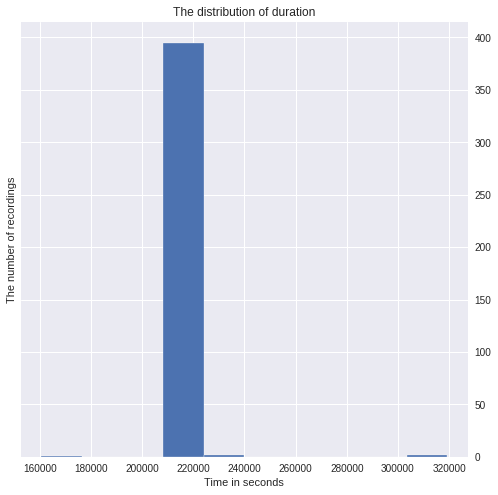

In [9]:
plt.figure(figsize=(8,8)) 
plt.title('The distribution of duration') 
plt.ylabel('The number of recordings') 
plt.xlabel('Time in seconds') 
durationHist = plt.hist(durations)

raw [-4.5113637e-07  2.0195017e-07  6.5901457e-07 ...  1.6507778e-06
  3.8245612e-06  5.9620647e-06]
220544
mfcc [[-6.1293848e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-6.1293848e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-6.1293848e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-6.1284003e+02  1.3920452e-01  1.3917354e-01 ...  1.3816851e-01
   1.3794851e-01  1.3770868e-01]
 [-6.1293848e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-6.1293848e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
431
frames 431
/content/gdrive/My Drive/ESC-10/005 - Clock tick/5-212181-A.ogg
raw [-4.5113637e-07  2.0195017e-07  6.5901457e-07 ...  1.6507778e-06
  3.8245612e-06  5.9620647e-06]
220544


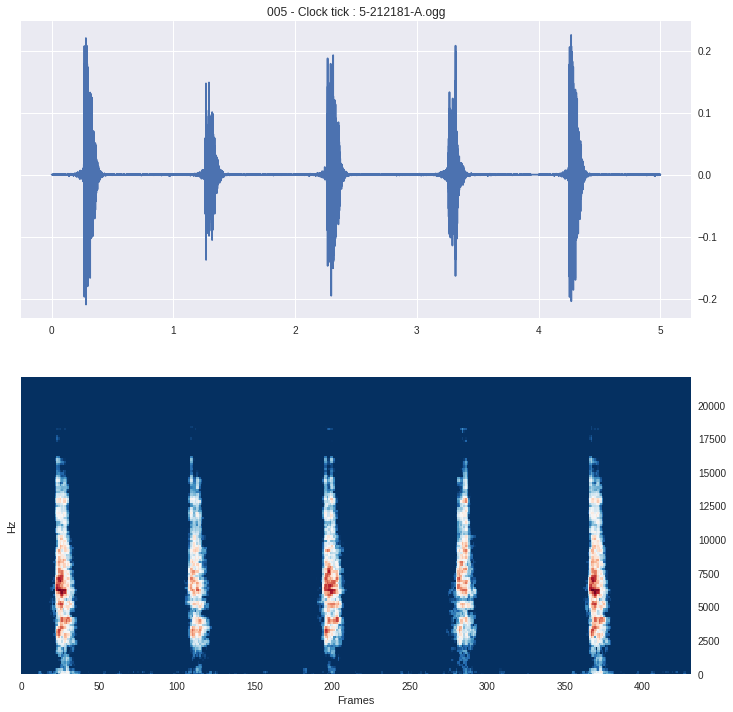

In [10]:

clip = Clip(all_recordings[132])    
print(clip.path)

with clip.audio as audio:
    plt.subplot(2, 1, 1)
    plt.title('{0} : {1}'.format(clip.category, clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
    plt.subplot(2, 1, 2)
    librosa.display.specshow(clip.logamplitude, sr=44100, x_axis='frames', y_axis='linear', cmap='RdBu_r')
    

IPython.display.Audio(filename=clip.path, rate=Clip.RATE)

44100
(13, 431)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


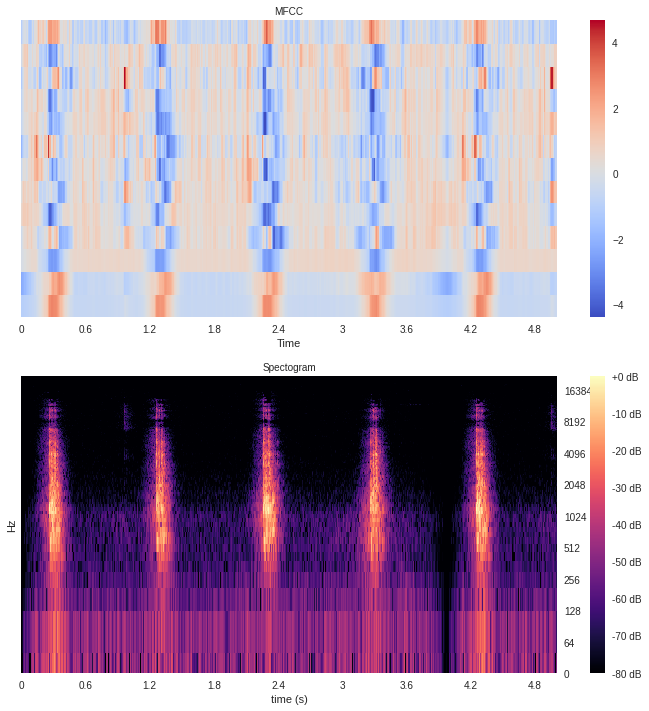

In [11]:
# For plotting

samples, sample_rate = librosa.load(clip.path, sr=Clip.RATE)
print(sample_rate)

plt.figure()
plt.subplot(211)

smpMfcc = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=13)
smpMfcc = sklearn.preprocessing.scale(smpMfcc, axis=1)
print(smpMfcc.shape)

librosa.display.specshow(smpMfcc, sr=sample_rate, hop_length=512, x_axis='time')
plt.title('MFCC',fontsize=10)
plt.colorbar()

plt.subplot(212)
smpFft = np.abs(np.fft.fft(samples)) 
smpFft = smpFft[:int(Clip.RATE/2)]
fftSize = 512
smpStft = np.abs(librosa.stft(y=samples, n_fft=fftSize)) 
spectogram = librosa.amplitude_to_db(smpStft, ref=np.max) 
librosa.display.specshow(spectogram, sr=sample_rate, hop_length=fftSize/4, y_axis='log', x_axis='time') 
plt.title('Spectogram',fontsize=10) 
plt.xlabel('time (s)') 
plt.colorbar(format='%+2.0f dB')


                0           1           2    ...         428         429         430
MFCC_0  -612.938477 -612.938477 -612.938477  ... -612.840027 -612.938477 -612.938477
MFCC_1     0.000000    0.000000    0.000000  ...    0.139205    0.000000    0.000000
MFCC_2     0.000000    0.000000    0.000000  ...    0.139174    0.000000    0.000000
MFCC_3     0.000000    0.000000    0.000000  ...    0.139121    0.000000    0.000000
MFCC_4     0.000000    0.000000    0.000000  ...    0.139048    0.000000    0.000000
MFCC_5     0.000000    0.000000    0.000000  ...    0.138953    0.000000    0.000000
MFCC_6     0.000000    0.000000    0.000000  ...    0.138838    0.000000    0.000000
MFCC_7     0.000000    0.000000    0.000000  ...    0.138702    0.000000    0.000000
MFCC_8     0.000000    0.000000    0.000000  ...    0.138543    0.000000    0.000000
MFCC_9     0.000000    0.000000    0.000000  ...    0.138367    0.000000    0.000000
MFCC_10    0.000000    0.000000    0.000000  ...    0.138169    0

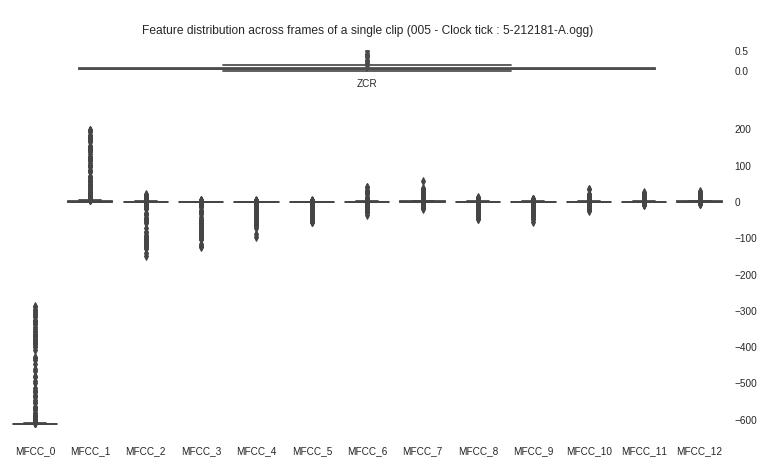

In [12]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], facecolor='w')
def plot_single_clip(clip):
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clip.mfcc)[1]))
    MFCC = pd.DataFrame(clip.mfcc[:, :], columns=col_names)
    ZCR = pd.DataFrame(clip.zcr, columns=['ZCR'])
    print(MFCC.transpose())
    print(ZCR.transpose())
    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-400, 400)
    ax_zcr = add_subplot_axes(ax, [0.0, 0.85, 1.0, 0.05])
    ax_zcr.set_xlim(0.0, 1.0)

    plt.title('Feature distribution across frames of a single clip ({0} : {1})'.format(clip.category, clip.filename), y=1.5)
    # bplot = sb.boxplot(y='lifeExp', x='continent', 
    #              data=gapminder_2007, 
    #              width=0.5,
    #              palette="colorblind")
    # dont forget the "data" argument
    sb.boxplot(data=MFCC, ax=ax_mfcc)
    sb.boxplot(data=ZCR,  ax=ax_zcr)
    
plot_single_clip(clip)

In [13]:

def load_dataset():
    """Load all dataset recordings into a nested list."""
    clips = []
    
    for directory in sorted(os.listdir()):
        if os.path.isdir(directory) and os.path.basename(directory)[0:3].isdigit():
            print('Parsing ' + directory)
            category = []
            for clip in sorted(os.listdir(directory)):
                if clip[-3:] == 'ogg':
                    clip = Clip('{0}/{1}'.format(directory, clip))
                    if len(clip.audio.raw) == 220544: # remove non-standard clip length, as this cause big issues
                        category.append(clip)
            clips.append(category)
            
    IPython.display.clear_output()
    print('All  recordings loaded.')            
    
    return clips

clips_10 = load_dataset()




All  recordings loaded.


In [14]:
print(clips_10)
print(clips_10[3]) # baby cry set

print(len(clips_10[3])) # 40 clips 

print(clips_10[3][0].filename)
print(clips_10[3][0].category)

print(clips_10[3][0].zcr)

print(clips_10[3][0].mfcc)


[[<001 - Dog bark/1-100032-A.ogg>, <001 - Dog bark/1-110389-A.ogg>, <001 - Dog bark/1-30226-A.ogg>, <001 - Dog bark/1-30344-A.ogg>, <001 - Dog bark/1-32318-A.ogg>, <001 - Dog bark/1-59513-A.ogg>, <001 - Dog bark/1-85362-A.ogg>, <001 - Dog bark/1-97392-A.ogg>, <001 - Dog bark/2-114280-A.ogg>, <001 - Dog bark/2-114587-A.ogg>, <001 - Dog bark/2-116400-A.ogg>, <001 - Dog bark/2-117271-A.ogg>, <001 - Dog bark/2-118072-A.ogg>, <001 - Dog bark/2-118964-A.ogg>, <001 - Dog bark/2-122104-A.ogg>, <001 - Dog bark/2-122104-B.ogg>, <001 - Dog bark/3-136288-A.ogg>, <001 - Dog bark/3-144028-A.ogg>, <001 - Dog bark/3-155312-A.ogg>, <001 - Dog bark/3-157695-A.ogg>, <001 - Dog bark/3-163459-A.ogg>, <001 - Dog bark/3-170015-A.ogg>, <001 - Dog bark/3-180256-A.ogg>, <001 - Dog bark/3-180977-A.ogg>, <001 - Dog bark/4-182395-A.ogg>, <001 - Dog bark/4-183992-A.ogg>, <001 - Dog bark/4-184575-A.ogg>, <001 - Dog bark/4-191687-A.ogg>, <001 - Dog bark/4-192236-A.ogg>, <001 - Dog bark/4-194754-A.ogg>, <001 - Dog bar

In [15]:
file_to_store = open("clips.pickle", "wb")
pickle.dump(clips_10, file_to_store)
file_to_store.close()

37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


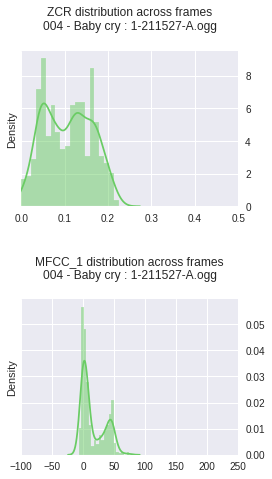

In [16]:
def plot_single_feature_one_clip(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.10)
    sb.distplot(feature, bins=20, hist=True, rug=False,
                hist_kws={"histtype": "stepfilled", "alpha": 0.5},
                kde_kws={"shade": False},
                color=sb.color_palette("muted", 4)[2], ax=ax)

def plot_single_feature_all_clips(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.03)
    sb.boxplot(feature, vert=False, order=list(reversed(feature.columns)), ax=ax)

def plot_single_feature_aggregate(feature, title, ax):    
    sb.despine()
    ax.set_title(title, y=1.03)
    sb.distplot(feature, bins=20, hist=True, rug=False,
                hist_kws={"histtype": "stepfilled", "alpha": 0.5},
                kde_kws={"shade": False},
                color=sb.color_palette("muted", 4)[1], ax=ax)

def generate_feature_summary(category, clip, coefficient):
    title = "{0} : {1}".format(clips_10[category][clip].category, clips_10[category][clip].filename)
    MFCC = pd.DataFrame()
    aggregate = []
    for i in range(0, len(clips_10[category])): # 40
        print(len(clips_10[category]))
        MFCC[i] = clips_10[category][i].mfcc[:, coefficient]
        aggregate = np.concatenate([aggregate, clips_10[category][i].mfcc[:, coefficient]])    

    f = plt.figure(figsize=(14, 12))
    f.subplots_adjust(hspace=0.6, wspace=0.3)

    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 0))


    ax1.set_xlim(0.0, 0.5)
    ax2.set_xlim(-100, 250)

    plot_single_feature_one_clip(clips_10[category][clip].zcr, 'ZCR distribution across frames\n{0}'.format(title), ax1)
    plot_single_feature_one_clip(clips_10[category][clip].mfcc[:, coefficient], 'MFCC_{0} distribution across frames\n{1}'.format(coefficient, title), ax2)

generate_feature_summary(3, 0, 1)

In [17]:
# for loading all training features into a dataset
def create_set(clips):
    cases = pd.DataFrame()

    for c in range(0, len(clips)): # categories
        cat = clips[c][0].category 
        print(cat)
        for i in range(0, len(clips[c])): 
            case = pd.DataFrame([clips[c][i].filename], columns=['filename'])
            case['category'] = cat[0:4] # category code only
            case['category_name'] = clips[c][i].category
            case['fold'] = clips[c][i].filename[0]
            
            mfcc_mean = pd.DataFrame(np.mean(clips[c][i].mfcc[:, :], axis=0)[1:]).T
            mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[1:]
            mfcc_std = pd.DataFrame(np.std(clips[c][i].mfcc[:, :], axis=0)[1:]).T
            mfcc_std.columns = list('MFCC_{} std dev'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[1:]
            case = case.join(mfcc_mean)
            case = case.join(mfcc_std)
            
            case['ZCR mean'] = np.mean(clips[c][i].zcr)
            case['ZCR std dev'] = np.std(clips[c][i].zcr)

            cases = cases.append(case)
            
    
    cases[['category', 'fold']] = cases[['category', 'fold']].astype(int)
    return cases

In [18]:
def create_data(clip):
    case = pd.DataFrame([clip.filename], columns=['filename'])

    mfcc_mean = pd.DataFrame(np.mean(clip.mfcc[:, :], axis=0)[1:]).T
    mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(clip.mfcc)[1]))[1:]
    mfcc_std = pd.DataFrame(np.std(clip.mfcc[:, :], axis=0)[1:]).T
    mfcc_std.columns = list('MFCC_{} std dev'.format(i) for i in range(np.shape(clip.mfcc)[1]))[1:]
    case = case.join(mfcc_mean)
    case = case.join(mfcc_std)
    
    case['ZCR mean'] = np.mean(clip.zcr)
    case['ZCR std dev'] = np.std(clip.zcr)



    return case

In [19]:
# create dataset
cases_10 = create_set(clips_10)
# each row is a clip
print(cases_10)
print(cases_10['category'])
print(cases_10.columns)

001 - Dog bark
002 - Rain
003 - Sea waves
004 - Baby cry
005 - Clock tick
006 - Person sneeze
007 - Helicopter
008 - Chainsaw
009 - Rooster
010 - Fire crackling
          filename  category  ...  ZCR mean  ZCR std dev
0   1-100032-A.ogg         1  ...  0.013145     0.061023
0   1-110389-A.ogg         1  ...  0.003594     0.018404
0    1-30226-A.ogg         1  ...  0.026339     0.021595
0    1-30344-A.ogg         1  ...  0.042764     0.026268
0    1-32318-A.ogg         1  ...  0.077687     0.057590
..             ...       ...  ...       ...          ...
0   5-193473-A.ogg        10  ...  0.353551     0.082023
0   5-193473-B.ogg        10  ...  0.406526     0.060489
0   5-213802-A.ogg        10  ...  0.065220     0.052100
0   5-215658-A.ogg        10  ...  0.012782     0.015473
0   5-215658-B.ogg        10  ...  0.011351     0.009682

[380 rows x 30 columns]
0     1
0     1
0     1
0     1
0     1
     ..
0    10
0    10
0    10
0    10
0    10
Name: category, Length: 380, dtype: int64


In [20]:
import sklearn as sk
import sklearn.ensemble

features_start = 'MFCC_1 mean'
features_end = 'ZCR std dev'


def to_percentage(number):
    return int(number * 1000) / 10.0

In [23]:


def classify(cases, classifier='knn', PCA=False, debug=False):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, 6):
        train = cases[cases['fold'] != fold].copy() # get the rows that are not the current fold
        test = cases[cases['fold'] == fold].copy()
        classifier_name = ''

        if PCA:
            pca = sk.decomposition.PCA()
            pca.fit(train.loc[:, features_start:features_end])
            train.loc[:, features_start:features_end] = pca.transform(train.loc[:, features_start:features_end])
            test.loc[:, features_start:features_end] = pca.transform(test.loc[:, features_start:features_end])

        if classifier == 'knn':
            classifier_name = 'k-NN'
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=8)
            knn.fit(train.loc[:, features_start:features_end], train['category']) # get the columns that are related to features
            test.loc[:, 'prediction'] = knn.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'rf':
            classifier_name = 'Random Forest'
            rf = sk.ensemble.RandomForestClassifier(n_estimators=500, random_state=20150420)
            rf.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = rf.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'svm':
            classifier_name = 'Support Vector Machine (SVM)'
            svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20150420)
            svm.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = svm.predict(test.loc[:, features_start:features_end])

        accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        results.append(accuracy)
        confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
        confusion = confusion + confusion_current
        
        print ('Classifying fold {0} with {1} classifier. Accuracy: {2}%'.format(fold, classifier_name, to_percentage(accuracy)))
        if debug:
            print ('Confusion matrix:\n', confusion_current, '\n')
        
    print ('Average accuracy: {0}%\n'.format(to_percentage(np.mean(results))))
    return confusion, results


confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm')
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn')


Classifying fold 1 with Random Forest classifier. Accuracy: 61.9%
Classifying fold 2 with Random Forest classifier. Accuracy: 72.3%
Classifying fold 3 with Random Forest classifier. Accuracy: 64.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 68.8%
Classifying fold 5 with Random Forest classifier. Accuracy: 67.5%
Average accuracy: 67.0%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 63.3%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 68.4%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 60.7%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 64.9%
Classifying fold 5 with Support Vector Machine (SVM) classifier. Accuracy: 61.0%
Average accuracy: 63.7%

Classifying fold 1 with k-NN classifier. Accuracy: 52.1%
Classifying fold 2 with k-NN classifier. Accuracy: 56.5%
Classifying fold 3 with k-NN classifier. Accuracy: 58.2%
Classifying fold 4 with k-NN classifier. Acc

In [ ]:
# training a Random Forrest classifier
filename = 'rf.sav'
PCA = False
results = []
best_accuracy = 0
class_count = len(cases_10['category'].unique())
confusion = np.zeros((class_count, class_count), dtype=int)

for fold in range(1, 6):
    train = cases_10[cases_10['fold'] != fold].copy()
    test = cases_10[cases_10['fold'] == fold].copy()
    classifier_name = ''

    if PCA:
        pca = sk.decomposition.PCA()
        pca.fit(train.loc[:, features_start:features_end])
        train.loc[:, features_start:features_end] = pca.transform(train.loc[:, features_start:features_end])
        test.loc[:, features_start:features_end] = pca.transform(test.loc[:, features_start:features_end])
    rf = sk.ensemble.RandomForestClassifier(n_estimators=500, random_state=20150420)
    rf.fit(train.loc[:, features_start:features_end], train['category'])
    test.loc[:, 'prediction'] = rf.predict(test.loc[:, features_start:features_end])
    accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
    results.append(accuracy)
    confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
    confusion = confusion + confusion_current

    if accuracy>best_accuracy:
        best_accuracy = accuracy
        model_file = open(filename, 'wb')
        pickle.dump(rf, model_file)
        model_file.close()

    print ('Classifying fold {0} with {1} classifier. Accuracy: {2}%'.format(fold, classifier_name, to_percentage(accuracy)))

print ('Average accuracy: {0}%\n'.format(to_percentage(np.mean(results))))

Classifying fold 1 with  classifier. Accuracy: 61.9%
Classifying fold 2 with  classifier. Accuracy: 72.3%
Classifying fold 3 with  classifier. Accuracy: 64.5%
Classifying fold 4 with  classifier. Accuracy: 68.8%
Classifying fold 5 with  classifier. Accuracy: 67.5%
Average accuracy: 67.0%



In [ ]:
# training a SVM classifier

filename = 'svm.sav'
PCA = False
results = []
class_count = len(cases_10['category'].unique())
confusion = np.zeros((class_count, class_count), dtype=int)
best_accuracy = 0
for fold in range(1, 6):
    train = cases_10[cases_10['fold'] != fold].copy()
    test = cases_10[cases_10['fold'] == fold].copy()
    classifier_name = ''

    if PCA:
        pca = sk.decomposition.PCA()
        pca.fit(train.loc[:, features_start:features_end])
        train.loc[:, features_start:features_end] = pca.transform(train.loc[:, features_start:features_end])
        test.loc[:, features_start:features_end] = pca.transform(test.loc[:, features_start:features_end])
    svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20150420)
    svm.fit(train.loc[:, features_start:features_end], train['category'])
    test.loc[:, 'prediction'] = svm.predict(test.loc[:, features_start:features_end])

    accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
    results.append(accuracy)
    confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
    confusion = confusion + confusion_current

    print ('Classifying fold {0} with {1} classifier. Accuracy: {2}%'.format(fold, classifier_name, to_percentage(accuracy)))
    if accuracy>best_accuracy:
        best_accuracy = accuracy
        model_file = open(filename, 'wb')
        pickle.dump(svm, model_file)
        model_file.close()

print ('Average accuracy: {0}%\n'.format(to_percentage(np.mean(results))))

Classifying fold 1 with  classifier. Accuracy: 63.3%
Classifying fold 2 with  classifier. Accuracy: 68.4%
Classifying fold 3 with  classifier. Accuracy: 60.7%
Classifying fold 4 with  classifier. Accuracy: 64.9%
Classifying fold 5 with  classifier. Accuracy: 61.0%
Average accuracy: 63.7%



In [24]:
print(confusion_10_rf)

[[29  0  1  3  2  3  0  0  2  0]
 [ 0 25  2  1  1  0  5  2  0  1]
 [ 0  1 29  0  0  1  3  4  0  1]
 [ 4  0  0 27  3  2  0  0  1  0]
 [ 3  0  0  6 12  6  2  0  1  6]
 [ 1  0  0  3  2 34  0  0  0  0]
 [ 0  8  3  0  2  0 21  0  0  4]
 [ 0  3  7  0  1  0  4 22  0  1]
 [ 3  0  0  1  2  0  0  0 34  0]
 [ 0  0  0  0  7  1  4  1  0 22]]


In [26]:
print(confusion_10_svm)

[[28  1  0  0  1  6  0  0  4  0]
 [ 0 25  2  1  0  1  6  2  0  0]
 [ 0  1 25  0  0  0  7  6  0  0]
 [ 6  0  0 29  2  0  0  0  0  0]
 [ 6  1  1  1 14  6  1  0  1  5]
 [ 2  0  0  1  3 34  0  0  0  0]
 [ 1 13  2  0  3  0 16  0  0  3]
 [ 0 11 11  0  0  0  1 15  0  0]
 [ 4  0  0  1  1  0  0  0 34  0]
 [ 0  1  0  0  4  1  6  1  0 22]]


In [27]:
print(confusion_10_knn)

[[27  0  0  0  4  6  0  0  3  0]
 [ 0 19  6  1  1  0  3  5  0  2]
 [ 0  1 29  0  1  0  5  3  0  0]
 [ 9  0  0 21  2  5  0  0  0  0]
 [ 3  0  0  3  9 12  1  1  0  7]
 [ 0  0  0  1  1 38  0  0  0  0]
 [ 0  1  7  1  2  0 17  0  0 10]
 [ 0 10 11  0  1  0  2 12  0  2]
 [ 2  0  0  2  1  4  0  0 31  0]
 [ 0  0  0  0  6  3  6  0  0 20]]


In [ ]:
# get a random clip and test
test_clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])

test_row = create_data(test_clip)

x = test_row.loc[:, features_start:features_end]
# print(test_row[:,features_start:features_end].head())
svm_model_file = open('svm.sav', 'rb')
loaded_svm_model = pickle.load(svm_model_file)
svm_model_file.close()

y_prediction = loaded_svm_model.predict(x)[0]
y_prediction = '00{0}'.format(y_prediction)
y_actual = test_clip.category[0:3]
print('actual', y_actual)
print('prediction', y_prediction)
IPython.display.Audio(filename=test_clip.path, rate=Clip.RATE)

raw [-2.8016327e-02 -2.4805473e-02 -6.2836357e-03 ... -1.6331698e-05
 -1.2545443e-05 -4.8679794e-08]
220544
mfcc [[-1.91712814e+02  7.05877457e+01 -5.58416977e+01 ...  6.28461933e+00
   4.50891113e+01 -2.84059410e+01]
 [-1.98292313e+02  5.69215469e+01 -6.06173210e+01 ...  8.22340965e+00
   4.51255722e+01 -3.10869026e+01]
 [-1.91507126e+02  5.62850113e+01 -6.80705719e+01 ...  1.38514299e+01
   4.42237778e+01 -3.56637268e+01]
 ...
 [-3.75689056e+02  8.45919609e-01  8.45728695e-01 ...  8.39621365e-01
   8.38287055e-01  8.36827040e-01]
 [-3.76210663e+02  1.08282998e-01  1.08258054e-01 ...  1.07476279e-01
   1.07305989e-01  1.07117645e-01]
 [-3.76287262e+02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
431
frames 431
actual 004
prediction 004


In [ ]:
# get a random clip and test
test_clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])

test_row = create_data(test_clip)

x = test_row.loc[:, features_start:features_end]
# print(test_row[:,features_start:features_end].head())
rf_model_file = open('rf.sav', 'rb')
loaded_rf_model = pickle.load(rf_model_file)
rf_model_file.close()

y_prediction = loaded_rf_model.predict(x)[0]
y_prediction = '00{0}'.format(y_prediction)
y_actual = test_clip.category[0:3]
print('actual', y_actual)
print('prediction', y_prediction)
IPython.display.Audio(filename=test_clip.path, rate=Clip.RATE)

raw [ 4.1006814e-04  4.8687193e-04  3.5114263e-04 ...  5.6672479e-06
  8.6999316e-05 -1.9396056e-04]
220544
mfcc [[-3.66998291e+02  1.91148415e+01 -1.01309896e+00 ...  2.75942111e+00
   1.03029490e+01  8.09167099e+00]
 [-2.36343658e+02  1.17487915e+02 -2.00081043e+01 ... -6.69951677e+00
   1.87648811e+01  4.99222088e+00]
 [-1.66760864e+02  1.63927322e+02 -2.94570789e+01 ... -1.20976267e+01
   7.34340382e+00  3.49726915e+00]
 ...
 [-2.93337158e+02  8.49940033e+01  1.72427464e+01 ... -3.33946896e+00
   1.72936594e+00 -4.32182646e+00]
 [-2.86320862e+02  9.46124420e+01  2.43295021e+01 ... -2.20472956e+00
  -7.42830038e-02 -6.92202330e+00]
 [-2.77587708e+02  1.04373199e+02  2.62046280e+01 ...  4.34980345e+00
   4.17007923e+00 -2.95595312e+00]]
431
frames 431
actual 003
prediction 003


In [ ]:
# use a actual voice clip to test
random_recordings = glob.glob('../Random Test Set/*.*')
random_clip = Clip(random_recordings[random.randint(0, len(random_recordings) - 1)])

random_row = create_data(random_clip)

x = random_row.loc[:, features_start:features_end]
y_prediction = svm.predict(x)[0]
y_prediction = '00{0}'.format(y_prediction)

print(random_clip.filename)
print('prediction', y_prediction)

IPython.display.Audio(filename=random_clip.path, rate=Clip.RATE)

Output hidden; open in https://colab.research.google.com to view.

Now clicing the audio

In [ ]:
import os
import glob
from pydub import AudioSegment
import argparse
import audioread
import time

def slice_audio(files, channels, outformat, width, rate, slice_length, slide):
	outformat = outformat.replace('.','').lower()
	#Allow the user to see their x-bit selection with this dictionary.
	width_translator = {1:'8-bit', 2:'16-bit', 4:'32-bit'}
	#For every file in the input list do processing.
	for file in files:
		fileName, fileExtension = os.path.splitext(file)
		#Print to screen the processing parameters.
		with audioread.audio_open(file) as f:
			print('\nConverting '+fileName+' from:')
			print(fileExtension+' to .'+outformat+';')
			print(str(f.channels)+' channel(s) to '+str(channels)+' channel(s);')
			print(str(f.samplerate)+' Hz to '+str(rate)+' Hz;')
			print('Slicing '+str(f.duration*1000)+' ms file into '+str(slice_length)+' ms slices with a window slide of '+str(slide)+' ms;')
		#Store the file in RAM.
		sound = AudioSegment.from_file(file, fileExtension.replace('.','').lower())
		#Print the 'x-bit' conversion parameters.
		print(width_translator[sound.sample_width]+' to '+width_translator[int(width)]+'.\n')
		#Implement the user-selected or default (if nothing selected) parameters for processing.
		sound = sound.set_frame_rate(int(rate))
		sound = sound.set_sample_width(int(width))
		sound = sound.set_channels(int(channels))
		length_sound_ms = len(sound)
		length_slice_ms = int(slice_length)
		slice_start = 0
		#create audiosegment object
		#Begin slicing at the start of the file.
		while slice_start + length_slice_ms < length_sound_ms:
			sound_slice = sound[slice_start:slice_start+length_slice_ms]
			sound_slice.export(fileName+'.slice'+str(slice_start/1000)+'SecsTo'+str((slice_start+length_slice_ms)/1000)+'Secs.'+outformat, format=outformat)
			slice_start += int(slide)
		#When the slice is abutting the end of the file, output that slice too.'
		if slice_start + length_slice_ms >= length_sound_ms:
			sound_slice = sound[slice_start:length_sound_ms]
			sound_slice.export(fileName+'.slice'+str(slice_start/1000)+'SecsToEndFileAt'+str((length_sound_ms)/1000)+'Secs.'+outformat, format=outformat)


In [ ]:
os.chdir('/content/gdrive/My Drive/Random Test Set/')
!ls

baby-crying-01.wav   crowd-talking-10.mp3  man-giggling-01.wav
baby-crying-03.mp3   crowd-talking-3.wav   man-laughing-02.wav
baby-crying-04.wav   crowd-talking-7.wav
baby-whining-01.mp3  crowd-talking-9.mp3


In [ ]:

files = ['baby-crying-01.wav']
slice_audio(files=files, channels=2, outformat='wav', width=2, rate=48000, slice_length=5000, slide=5000)


Converting baby-crying-01 from:
.wav to .wav;
2 channel(s) to 2 channel(s);
48000 Hz to 48000 Hz;
Slicing 17000.0 ms file into 5000 ms slices with a window slide of 5000 ms;
32-bit to 16-bit.



In [ ]:
clip = Clip('baby-crying-01.wav')
with clip.audio as audio:
    plt.subplot(2, 1, 1)
    plt.title('{0} : {1}'.format(clip.category, clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
    plt.subplot(2, 1, 2)
    librosa.display.specshow(clip.logamplitude, sr=44100, x_axis='frames', y_axis='linear', cmap='RdBu_r')
    

IPython.display.Audio(filename=clip.path, rate=Clip.RATE)

Output hidden; open in https://colab.research.google.com to view.

raw [ 0.00083218  0.00095257 -0.000171   ... -0.0239734  -0.02075714
 -0.01571012]
220500
mfcc [[-2.9544626e+02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.9385492e+02  1.8617982e+00  8.6047113e-01 ...  4.3538883e-01
  -2.8471678e-01 -1.0763564e+00]
 [-2.7578317e+02  2.2178204e+01  8.3703747e+00 ...  1.3090261e+00
  -4.2498407e+00 -9.9126759e+00]
 ...
 [-2.6780893e+02  2.7340851e+01  2.9677591e+00 ... -9.8061552e+00
  -3.2776637e+00  9.7844893e-01]
 [-2.7025552e+02  2.5586845e+01  4.3127680e+00 ... -7.8204126e+00
  -1.7682134e+00  1.3861703e+00]
 [-2.7132791e+02  2.4424347e+01  3.2183208e+00 ... -5.8160162e+00
   1.1667354e+00  4.8191566e+00]]
431
frames 431
raw [ 0.00083218  0.00095257 -0.000171   ... -0.0239734  -0.02075714
 -0.01571012]
220500


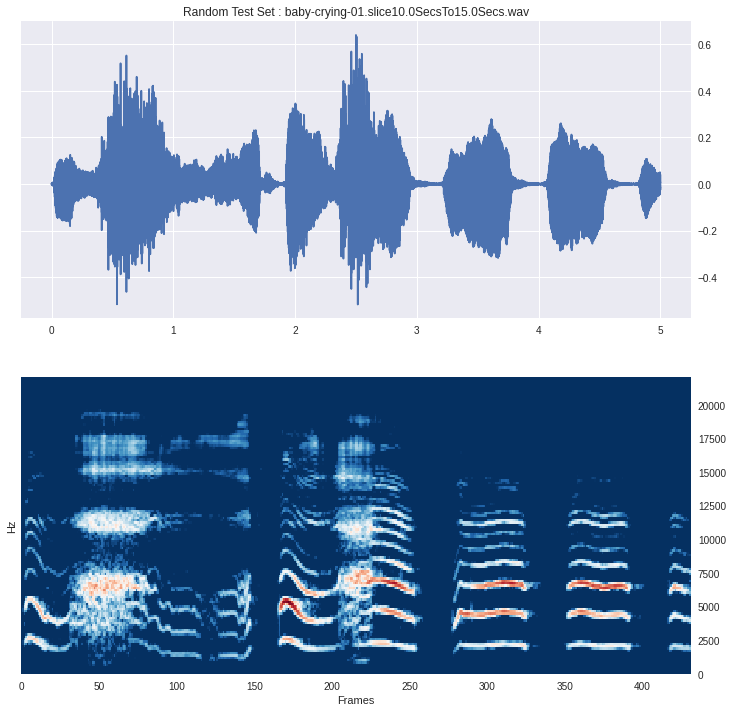

In [ ]:

clip = Clip('baby-crying-01.slice10.0SecsTo15.0Secs.wav')
with clip.audio as audio:
    plt.subplot(2, 1, 1)
    plt.title('{0} : {1}'.format(clip.category, clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
    plt.subplot(2, 1, 2)
    librosa.display.specshow(clip.logamplitude, sr=44100, x_axis='frames', y_axis='linear', cmap='RdBu_r')
    

IPython.display.Audio(filename=clip.path, rate=Clip.RATE)